# Описание проекта: промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать.

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Ниже расскажем о деталях этого процесса. Их важно знать, прежде чем генерировать новые признаки.

**Цель проекта**

Оптимизация производственных расходов металлургического комбината, с помощью построения модели машинного обучения, которая предсказывает температуру сплава.

Модель позволит снизить затраты на электричество, обслуживание и ремонты.

- Целевая переменная target - последняя температура по всей партии 
- Целевая метрика - MAE (нужно получить не более 6.8 на тесте)

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»).

**Описание данных**

Данные состоят из нескольких файлов, полученных из разных источников:
    
- `data_arc_new.csv` — данные об электродах;

- `data_bulk_new.csv` — данные о подаче сыпучих материалов (объём);

- `data_bulk_time_new.csv` — данные о подаче сыпучих материалов (время);

- `data_gas_new.csv` — данные о продувке сплава газом;

- `data_temp_new.csv` — результаты измерения температуры;

- `data_wire_new.csv` — данные о проволочных материалах (объём);

- `data_wire_time_new.csv` — данные о проволочных материалах (время).

**Файл `data_arc_new.csv`**

- `key` — номер партии;
- `Начало нагрева дугой` — время начала нагрева;
- `Конец нагрева дугой` — время окончания нагрева;
- `Активная мощность` — значение активной мощности;
- `Реактивная мощность` — значение реактивной мощности.

**Файл `data_bulk_new.csv`**

- `key` — номер партии;
- `Bulk 1` … `Bulk 15` — объём подаваемого материала.

**Файл `data_bulk_time_new.csv`**

- `key` — номер партии;
- `Bulk 1` … `Bulk 15` — время подачи материала.

**Файл `data_gas_new.csv`**

- `key` — номер партии;
- `Газ 1` — объём подаваемого газа.

**Файл `data_temp_new.csv`**

- `key` — номер партии;
- `Время замера` — время замера;
- `Температура` — значение температуры.

**Файл `data_wire_new.csv`**

- `key` — номер партии;
- `Wire 1` … `Wire 9` — объём подаваемых проволочных материалов.

**Файл `data_wire_time_new.csv`**

- `key` — номер партии;
- `Wire 1` … `Wire 9` — время подачи проволочных материалов.

**План работы**

1. Загрузка данных
2. Исследовательский анализ и предобработка данных
3. Объединение данных
4. Исследовательский анализ и предобработка данных объединённого датафрейма
5. Подготовка данных
6. Обучение моделей машинного обучения
7. Выбор лучшей модели
8. Общий вывод и рекомендации заказчику

## Импорт библиотек

In [1]:
!pip install missingno -q

In [2]:
import pandas as pd
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)

## Загрузка данных

### Файл `data_arc_new.csv`

**В нем хранятся данные об электродах**

- `key` — номер партии;
- `Начало нагрева дугой` — время начала нагрева;
- `Конец нагрева дугой` — время окончания нагрева;
- `Активная мощность` — значение активной мощности;
- `Реактивная мощность` — значение реактивной мощности.

**Активная мощность** — это часть электроэнергии, которая напрямую преобразуется в полезные действия: нагревание, свечение ламп, вращение двигателей и другие виды работы. Именно её учёт ведётся в бытовых счётчиках, а измеряется она в ваттах (Вт) и киловаттах (кВт).

**Реактивная мощность** — это энергия, временно запасаемая в электромагнитных полях устройств (например, в катушках или конденсаторах), которая не расходуется на совершение работы, но циркулирует между источником и нагрузкой. Из-за неё возрастают потери в проводах и увеличивается нагрузка на оборудование, хотя сама по себе она не производит полезного эффекта.

In [3]:
try:
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
except:
    data_arc = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
data_arc.head(10)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


### `data_bulk_new.csv`

**Здесь хранятся данные о подаче сыпучих материалов (объём)**

- `key` — номер партии;
- `Bulk 1` … `Bulk 15` — объём подаваемого материала.

In [4]:
try:
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv')
except:
    data_bulk = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
data_bulk.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


### `data_bulk_time_new.csv`

**Здесь хранятся данные о подаче сыпучих материалов (время)**\

- `key` — номер партии;
- `Bulk 1` … `Bulk 15` — время подачи материала.

In [5]:
try:
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
except:
    data_bulk_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
data_bulk_time.head(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


### `data_gas_new.csv`

**Здесь хранятся данные о продувке сплава газом**

- `key` — номер партии;
- `Газ 1` — объём подаваемого газа.

In [6]:
try:
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
except:
    data_gas = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
data_gas.head(10)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


### `data_temp_new.csv`

**Здесь хранятся данные о результатах измерения температуры**

- `key` — номер партии;
- `Время замера` — время замера;
- `Температура` — значение температуры.

In [7]:
try:
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
except:
    data_temp = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
data_temp.head(10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


### `data_wire_new.csv`

**Здесь хранятся данные о проволочных материалах (объём)**

- `key` — номер партии;
- `Wire 1` … `Wire 9` — объём подаваемых проволочных материалов.

In [8]:
try:
    data_wire = pd.read_csv('/datasets/data_wire_new.csv')
except:
    data_wire = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
data_wire.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### `data_wire_time_new.csv`

**Здесь хранятся данные о проволочных материалах (время)**

- `key` — номер партии;
- `Wire 1` … `Wire 9` — время подачи проволочных материалов.

In [9]:
try:
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_wire_time = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')
data_wire_time.head(10)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Вывод по загрузке данных

- Данные, предоставленные заказчиком, успешно загружены и соответствуют заявленному описанию.
- Наименования столбцов не соответствуют установленным стандартам или ожидаемому формату.
- В ряде столбцов типы данных не согласуются с характером хранимой информации (например, числовые значения указаны как текстовые или наоборот).
- Присутствует несогласованность в единицах измерения — данные представлены в разных масштабах или размерностях.

Переходим к этапу исследовательского анализа данных.

## Исследовательский анализ и предобработка данных

### `data_arc_new.csv`

In [10]:
print('Описательная статистика')
data_arc.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2)

Описательная статистика


,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876,14876,14876.00,14876.00
unique,14876,14876,NaN,NaN
top,2019-05-03 12:53:12,2019-08-10 21:07:42,NaN,NaN
freq,1,1,NaN,NaN
mean,NaN,NaN,0.66,0.44
std,NaN,NaN,0.26,5.87
min,NaN,NaN,0.22,-715.48
25%,NaN,NaN,0.47,0.34
50%,NaN,NaN,0.60,0.44
75%,NaN,NaN,0.83,0.61


In [11]:
print('Информация\n')
data_arc.info()

Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [12]:
print('Процент наличия данных\n')
display(100 - (data_arc.isna().sum() / data_arc.shape[0] * 100.00))

Процент наличия данных



key                     100.0
Начало нагрева дугой    100.0
Конец нагрева дугой     100.0
Активная мощность       100.0
Реактивная мощность     100.0
dtype: float64

In [13]:
print(f'Количество явных дубликатов:{data_arc.duplicated().sum()}')

Количество явных дубликатов:0


Матрица пропущенных значений:


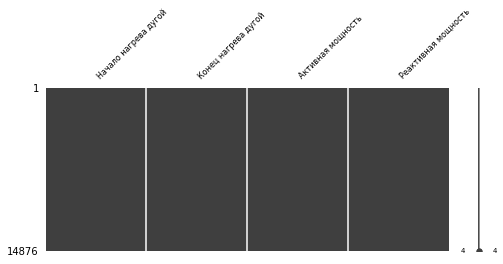

In [14]:
print('Матрица пропущенных значений:')
msno.matrix(data_arc.iloc[:,1:], figsize=(8, 3), fontsize=8);

Перед началом глубокого анализа проведём первичную диагностику датасета, чтобы понять структуру, качество и особенности данных.

Сначала выведем описательную статистику по всем столбцам (кроме первого, который, судя по коду, может быть идентификатором или индексом). Метод `.describe()` применён ко всем типам данных — числовым (`int`, `float`) и категориальным (`object`) — с округлением результатов до двух знаков после запятой для удобства восприятия. Это позволяет оценить распределение, центральные тенденции и разброс значений.

Далее — команда `.info()` даёт общую информацию о датасете: количество записей, типы данных в каждом столбце, объём используемой памяти, а также указывает на наличие пропусков.

Чтобы количественно оценить полноту данных, рассчитан процент заполненности каждого столбца: для этого количество пропущенных значений преобразовано в процент от общего числа строк. Чем ближе показатель к 100%, тем полнее столбец.

Также проверено наличие явных дубликатов на уровне строк — если такие есть, их количество будет выведено.

Для визуальной оценки пропусков построена матрица пропущенных значений с помощью библиотеки `missingno`. График наглядно показывает, где в данных есть пробелы, помогая выявить возможные закономерности в отсутствующих данных (например, системные пропуски в определённых строках или столбцах).

На основе полученной информации можно сделать выводы о необходимости предварительной обработки:
— переименовать столбцы для единообразия и соответствия стандартам (например, привести к нижнему регистру, заменить пробелы на подчёркивания);
— преобразовать формат даты в соответствующий тип `datetime`, чтобы в дальнейшем можно было проводить временной анализ, фильтрацию по периодам или агрегацию по дням, месяцам и т.д.

Эти шаги заложат надёжный фундамент для последующего исследовательского анализа и построения корректных выводов

In [15]:
data_arc = data_arc.rename(
    columns={
        'Начало нагрева дугой':'start_heating',
        'Конец нагрева дугой': 'finish_heating',
        'Активная мощность': 'active_power',
        'Реактивная мощность': 'reactive_power',
    }
)
data_arc['start_heating'] = pd.to_datetime(data_arc['start_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc['finish_heating'] = pd.to_datetime(data_arc['finish_heating'], format='%Y-%m-%d %H:%M:%S')
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   start_heating   14876 non-null  datetime64[ns]
 2   finish_heating  14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Анализ описательной статистики выявил наличие явного выброса — значение реактивной мощности отрицательное, что в контексте физического смысла показателя может быть необоснованным или ошибочным. Учитывая это, есть два подхода к обработке аномалии: замена выброса на медианное значение по столбцу или удаление строки с выбросом.

Общий объём данных составляет 14 876 строк, поэтому удаление одной записи окажет пренебрежимо малое влияние на общую выборку и не скажется существенно на качестве последующих моделей или выводов. В то же время замена на медиану может быть более консервативным решением, особенно если есть сомнения в полной достоверности исходного значения.

Выбор стратегии зависит от предметной области и допущений о природе данных — при однократном техническом сбое уместно удаление, при возможной погрешности измерения — импутация медианой.

In [16]:
data_arc.query('reactive_power < 0')

,key,start_heating,finish_heating,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [17]:
data_arc.query('key == 2116')

,key,start_heating,finish_heating,active_power,reactive_power
9778,2116,2019-07-28 02:07:12,2019-07-28 02:09:14,0.787549,0.693881
9779,2116,2019-07-28 02:13:10,2019-07-28 02:15:25,0.580263,0.411498
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
9781,2116,2019-07-28 02:29:11,2019-07-28 02:30:18,0.563641,0.408513


In [18]:
data_arc = data_arc.query('key != 2116')
data_arc.shape

(14872, 5)

Для более детального изучения аномалии с отрицательным значением реактивной мощности сначала были отфильтрованы строки, где `reactive_power < 0`, чтобы точно локализовать проблемную запись. Затем, зная, что выброс связан с записью под ключом `key == 2116`, было выполнено дополнительное фильтрование для проверки её содержимого.

После подтверждения аномалии строка с `key = 2116` была исключена из датасета с помощью условия `key != 2116`. Это позволило очистить данные от искажённого наблюдения. Проверка формы датасета после удаления подтвердила корректность операции — количество строк уменьшилось на одну.

Теперь, когда данные предварительно очищены, следующим шагом станет визуальный анализ распределений. Для этого построим **гистограммы** — чтобы оценить форму распределения признаков, их смещение и плотность значений. А также добавим **boxplot (ящик с усами)** — для выявления потенциальных выбросов, анализа разброса и медианного значения по каждому из параметров.

Такой подход сочетает количественный и графический анализ, что повышает надёжность интерпретации данных и помогает принять обоснованные решения на этапе подготовки к моделированию.

Введем функцию `f_hist_box` для дальнейшего анализа

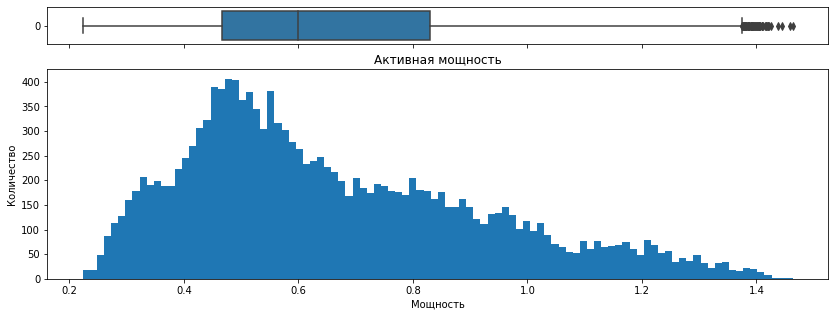

In [19]:
def f_hist_box(data, bins, title, xlabel, ylabel):
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(14,5), gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=[data], orient="h", ax=ax_box)
    plt.hist(data, bins=bins, range=(data.min(),data.max()))
 
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show();
    
f_hist_box(
    data=data_arc['active_power'],
    bins=100, 
    title='Активная мощность',
    xlabel='Мощность',
    ylabel='Количество'
)

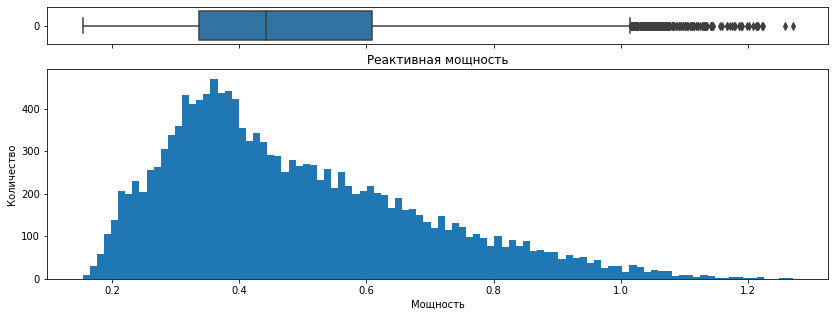

In [20]:
f_hist_box(
    data=data_arc['reactive_power'],
    bins=100, 
    title='Реактивная мощность',
    xlabel='Мощность',
    ylabel='Количество'
)

Для более полного анализа энергетических процессов добавим три расчётные величины:

- **Полную мощность** $ P $, которая определяется как гипотенуза прямоугольного треугольника активной и реактивной мощности:  
  $$
  P = \sqrt{A^2 + R^2}
  $$

- **Время нагрева в секундах** $ T $ — разница между временем окончания и начала процесса, переведённая в секунды.

- **Полную энергию** $ E $, накопленную за время нагрева:  
  $$
  E = P \cdot T
  $$

Эти параметры позволят точнее оценить энергозатраты процесса и улучшат качество признакового пространства для дальнейшего анализа или моделирования.

In [21]:
data_arc['full_power'] = (data_arc['active_power']**2 + data_arc['reactive_power']**2)**0.5
data_arc['heating_time'] = (data_arc['finish_heating'] - data_arc['start_heating']).dt.seconds
data_arc['full_energy'] = data_arc['full_power'] * data_arc['heating_time']
data_arc.head(10)

,key,start_heating,finish_heating,active_power,reactive_power,full_power,heating_time,full_energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,159.830252
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,0.440239,137,60.312695
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527,0.332731,338,112.463079
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962,0.860064,126,108.368056
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517,0.955315,210,200.616176
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856,1.373863,280,384.681584


Сгруппируем данные по номеру партии, агрегируя числовые параметры путём суммирования. Это позволит получить сводные показатели по каждой партии.

Дополнительно рассчитаем **количество циклов нагрева** для каждой партии — по числу записей в исходных данных, что соответствует количеству включений печи. Этот признак может оказаться полезным для анализа зависимости между числом нагревов и итоговыми характеристиками плавки.

Такой подход к агрегации помогает перейти от пооперационных данных к уровню партии, что упрощает анализ и построение моделей.

In [22]:
data_arc = data_arc.pivot_table(index='key',
                                values=['active_power',
                                        'reactive_power',
                                        'full_power',
                                        'heating_time',
                                        'full_energy',
                                        'start_heating'
                                       ],
                                aggfunc={'active_power': 'sum',
                                         'reactive_power': 'sum',
                                         'full_power': 'sum',
                                         'heating_time': 'sum',
                                         'full_energy': 'sum',
                                         'start_heating' : 'count'
                                        }).reset_index().rename(columns={'start_heating':'number_of_heating'}
)
data_arc.columns

Index(['key', 'active_power', 'full_energy', 'full_power', 'heating_time',
       'reactive_power', 'number_of_heating'],
      dtype='object')

In [23]:
data_arc = data_arc[['key',
                     'active_power',
                     'reactive_power',
                     'full_power',
                     'heating_time',
                     'full_energy',
                     'number_of_heating'
                    ]]
display(data_arc.shape)
data_arc.head(10)

(3213, 7)

,key,active_power,reactive_power,full_power,heating_time,full_energy,number_of_heating
0,1,3.036730,2.142821,3.718736,1098,770.282114,5
1,2,2.139408,1.453357,2.588349,811,481.760005,4
2,3,4.063641,2.937457,5.019223,655,722.837668,5
3,4,2.706489,2.056992,3.400038,741,683.455597,4
4,5,2.252950,1.687991,2.816980,869,512.169934,4
5,6,2.725274,1.881313,3.313074,952,839.231310,4
6,7,2.626877,1.960419,3.283913,673,613.576982,4
7,8,2.678958,2.096952,3.405956,913,619.129542,4
8,9,3.520820,2.527365,4.335261,625,570.113675,5
9,10,3.118778,2.154941,3.791005,825,533.482050,6


Теперь построим **гистограммы данных** и **Boxplot**

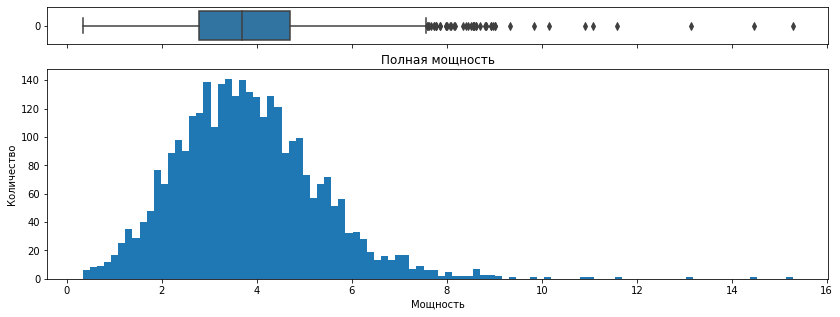

In [24]:
f_hist_box(
    data=data_arc['full_power'],
    bins=100, 
    title='Полная мощность',
    xlabel='Мощность',
    ylabel='Количество'
)

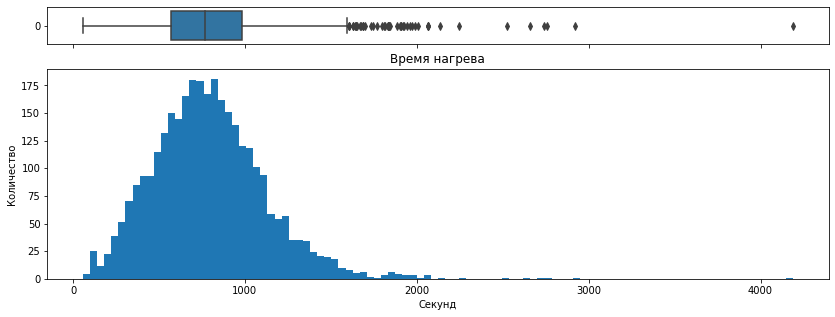

In [25]:
f_hist_box(
    data=data_arc['heating_time'],
    bins=100, 
    title='Время нагрева',
    xlabel='Секунд',
    ylabel='Количество'
)

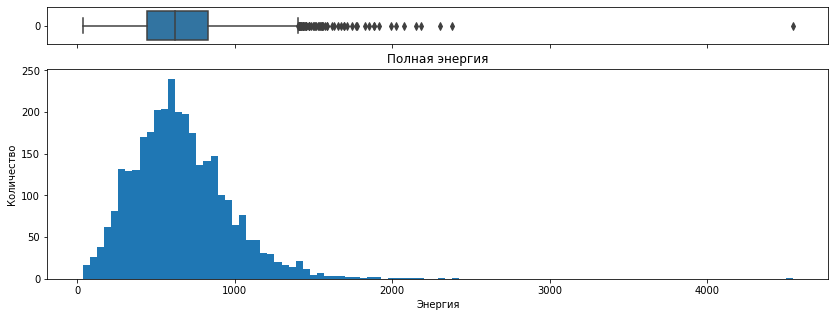

In [26]:
f_hist_box(
    data=data_arc['full_energy'],
    bins=100, 
    title='Полная энергия',
    xlabel='Энергия',
    ylabel='Количество'
)

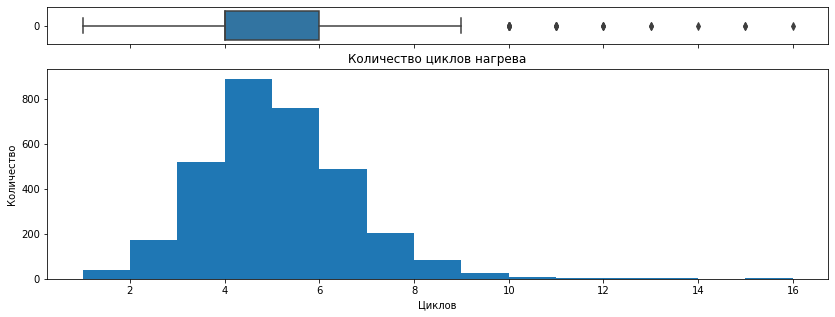

In [27]:
f_hist_box(
    data=data_arc['number_of_heating'],
    bins=15, 
    title='Количество циклов нагрева',
    xlabel='Циклов',
    ylabel='Количество'
)

### `data_bulk_new.csv`

In [28]:
print('Описалельная статистика')
data_bulk.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2)

Описалельная статистика


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252.00,22.00,1298.00,1014.00,77.00,576.00,25.00,1.0,19.00,176.00,177.00,2450.00,18.00,2806.00,2248.00
mean,39.24,253.05,113.88,104.39,107.03,118.93,305.60,49.0,76.32,83.28,76.82,260.47,181.11,170.28,160.51
std,18.28,21.18,75.48,48.18,81.79,72.06,191.02,NaN,21.72,26.06,59.66,120.65,46.09,65.87,51.77
min,10.00,228.00,6.00,12.00,11.00,17.00,47.00,49.0,63.00,24.00,8.00,53.00,151.00,16.00,1.00
25%,27.00,242.00,58.00,72.00,70.00,69.75,155.00,49.0,66.00,64.00,25.00,204.00,153.25,119.00,105.00
50%,31.00,251.50,97.50,102.00,86.00,100.00,298.00,49.0,68.00,86.50,64.00,208.00,155.50,151.00,160.00
75%,46.00,257.75,152.00,133.00,132.00,157.00,406.00,49.0,70.50,102.00,106.00,316.00,203.50,205.75,205.00
max,185.00,325.00,454.00,281.00,603.00,503.00,772.00,49.0,147.00,159.00,313.00,1849.00,305.00,636.00,405.00


In [29]:
print('Информация\n')
data_bulk.info()

Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [30]:
print('Процент наличия данных')
display(100 - (data_bulk.isna().sum() / data_bulk.shape[0] * 100.00))

Процент наличия данных


key        100.000000
Bulk 1       8.053691
Bulk 2       0.703100
Bulk 3      41.482902
Bulk 4      32.406520
Bulk 5       2.460850
Bulk 6      18.408437
Bulk 7       0.798977
Bulk 8       0.031959
Bulk 9       0.607223
Bulk 10      5.624800
Bulk 11      5.656759
Bulk 12     78.299776
Bulk 13      0.575264
Bulk 14     89.677213
Bulk 15     71.844040
dtype: float64

In [31]:
print(f'Количество явных дубликатов:{data_bulk.duplicated().sum()}')

Количество явных дубликатов:0


Матрица пропущенных значений:


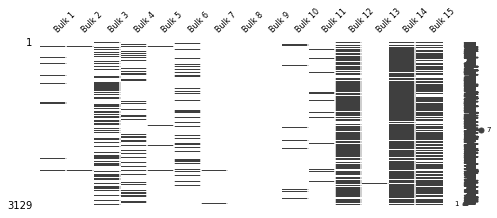

In [32]:
print('Матрица пропущенных значений:')
msno.matrix(data_bulk.iloc[:,1:], figsize=(8, 3), fontsize=8);

Дендограмма пропущенных значений:


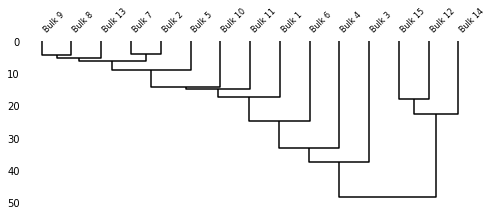

In [33]:
print('Дендограмма пропущенных значений:')
msno.dendrogram(data_bulk.iloc[:,1:], figsize=(8, 3), fontsize=8);

Далее займемся переименновкой стобцов

In [34]:
data_bulk.columns = data_bulk.columns.str.lower().str.replace(' ', '_')
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Приступим к обработке пропущенных значений. Столбцы, в которых доля пропусков превышает 80 %, не несут достаточной информативности и могут исказить анализ — такие признаки целесообразно удалить.

Оставшиеся пропуски, учитывая контекст данных, заполним нулевыми значениями. Такой подход подходит, например, для числовых параметров, где отсутствие записи логично интерпретировать как отсутствие события или нулевую активность (например, отсутствие подачи компонента или неиспользование ресурса).

Этот шаг упрощает структуру данных и готовит их к дальнейшей агрегации, визуализации или моделированию.

In [35]:
data_bulk = data_bulk[['key', 'bulk_12','bulk_14']]
data_bulk = data_bulk.fillna(0)
print(f'Количество пропусков в таблице:\n{data_bulk.isna().sum()}')

Количество пропусков в таблице:
key        0
bulk_12    0
bulk_14    0
dtype: int64


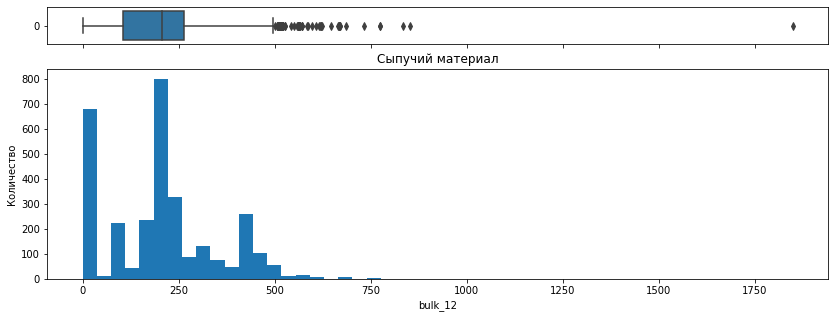

In [36]:
f_hist_box(
    data=data_bulk['bulk_12'],
    bins=50, 
    title='Сыпучий материал',
    xlabel='bulk_12',
    ylabel='Количество'
)

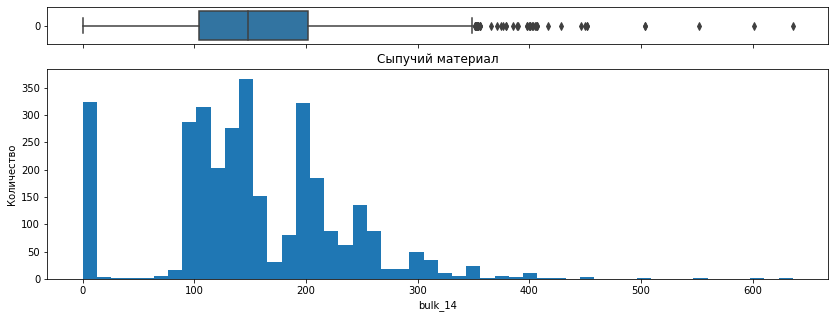

In [37]:
f_hist_box(
    data=data_bulk['bulk_14'],
    bins=50, 
    title='Сыпучий материал',
    xlabel='bulk_14',
    ylabel='Количество'
)

### `data_bulk_time_new.csv`

In [38]:
print('Описалельная статистика')
data_bulk_time.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2)

Описалельная статистика


,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,2019-05-29 11:07:59,2019-05-08 01:53:35,2019-08-18 05:07:43,2019-05-18 09:17:50,2019-08-12 22:28:59,2019-05-10 07:08:59,2019-07-20 23:48:47,2019-07-08 17:14:53,2019-08-16 08:40:51,2019-05-22 12:46:08,2019-08-18 05:07:43,2019-05-18 09:17:50,2019-06-01 18:07:38,2019-06-03 23:27:17,2019-05-06 03:11:38
freq,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [39]:
print('Информация\n')
data_bulk_time.info()

Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [40]:
print('Процент наличия данных')
display(100 - (data_bulk_time.isna().sum() / data_bulk_time.shape[0] * 100.00))

Процент наличия данных


key        100.000000
Bulk 1       8.053691
Bulk 2       0.703100
Bulk 3      41.482902
Bulk 4      32.406520
Bulk 5       2.460850
Bulk 6      18.408437
Bulk 7       0.798977
Bulk 8       0.031959
Bulk 9       0.607223
Bulk 10      5.624800
Bulk 11      5.656759
Bulk 12     78.299776
Bulk 13      0.575264
Bulk 14     89.677213
Bulk 15     71.844040
dtype: float64

In [41]:
print(f'Количество явных дубликатов:{data_bulk_time.duplicated().sum()}')

Количество явных дубликатов:0


Матрица пропущенных значений:


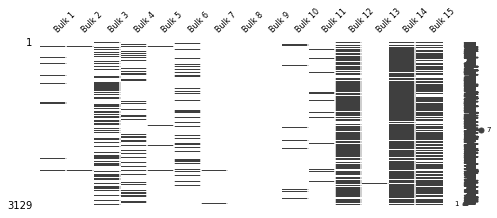

In [42]:
print('Матрица пропущенных значений:')
msno.matrix(data_bulk_time.iloc[:,1:], figsize=(8, 3), fontsize=8);

Дендограмма пропущенных значений:


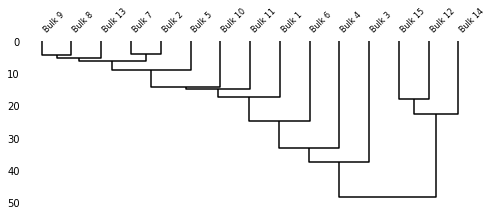

In [43]:
print('Дендограмма пропущенных значений:')
msno.dendrogram(data_bulk_time.iloc[:,1:], figsize=(8, 3), fontsize=8);

Анализ показал, что конечная температура расплава не имеет значимой связи со временем подачи сыпучих материалов. Учитывая это, данные о времени засыпки не будут включаться в обучающую выборку модели — они не вносят вклад в прогноз и могут лишь усложнить процесс обучения.

Ограничимся ознакомительной проверкой этих признаков на этапе разведывательного анализа, но исключим их из дальнейшей работы для повышения интерпретируемости и стабильности модели.

### `data_gas_new.csv`

In [44]:
print('Описалельная статистика')
data_gas.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2)

Описалельная статистика


,Газ 1
count,3239.00
mean,11.00
std,6.22
min,0.01
25%,7.04
50%,9.84
75%,13.77
max,78.00


In [45]:
print('Информация\n')
data_gas.info()

Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [46]:
print('Процент наличия данных')
display(100 - (data_gas.isna().sum() / data_gas.shape[0] * 100.00))

Процент наличия данных


key      100.0
Газ 1    100.0
dtype: float64

In [47]:
print(f'Количество явных дубликатов:{data_gas.duplicated().sum()}')

Количество явных дубликатов:0


Матрица пропущенных значений:


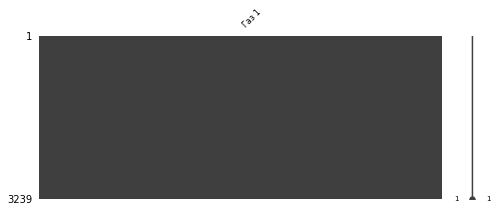

In [48]:
print('Матрица пропущенных значений:')
msno.matrix(data_gas.iloc[:,1:], figsize=(8, 3), fontsize=8);

По аналогии с предыдущими датасетами переименнуем столбцы

In [49]:
data_gas = data_gas.rename(columns={'Газ 1':'gas_1'})
data_gas.head(10)

,key,gas_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


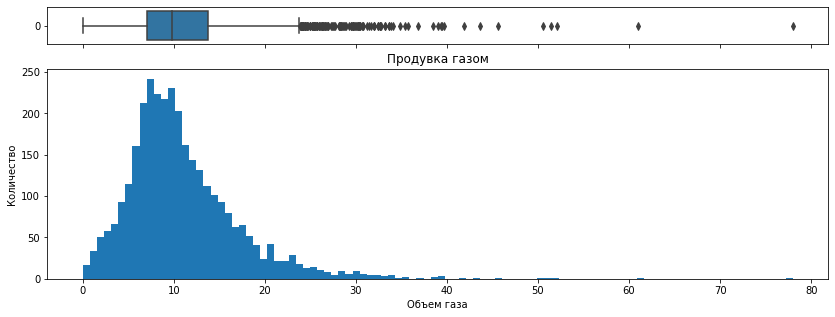

In [50]:
f_hist_box(
    data=data_gas['gas_1'],
    bins=100, 
    title='Продувка газом',
    xlabel='Объем газа',
    ylabel='Количество'
)

### `data_temp_new.csv`

In [51]:
print('Описалельная статистика')
data_temp.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2)

Описалельная статистика


,Время замера,Температура
count,18092,14665.00
unique,18092,NaN
top,2019-05-18 23:48:37,NaN
freq,1,NaN
mean,NaN,1590.72
std,NaN,20.39
min,NaN,1191.00
25%,NaN,1580.00
50%,NaN,1590.00
75%,NaN,1599.00


In [52]:
print('Информация\n')
data_temp.info()

Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [53]:
print('Процент наличия данных')
display(100 - (data_temp.isna().sum() / data_temp.shape[0] * 100.00))

Процент наличия данных


key             100.000000
Время замера    100.000000
Температура      81.057926
dtype: float64

In [54]:
print(f'Количество явных дубликатов:{data_temp.duplicated().sum()}')

Количество явных дубликатов:0


Матрица пропущенных значений:


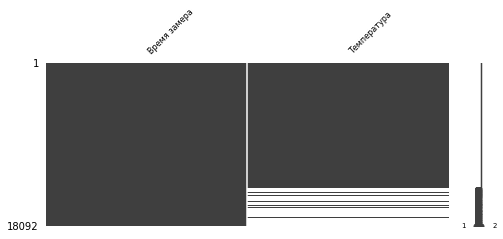

In [55]:
print('Матрица пропущенных значений:')
msno.matrix(data_temp.iloc[:,1:], figsize=(8, 3), fontsize=8);

Переименуем столцы изменим формат времени

In [56]:
data_temp = data_temp.rename(columns={'Время замера':'measuring_time',
                                      'Температура': 'temperature'
                                     }
)
data_temp['measuring_time'] = pd.to_datetime(data_temp['measuring_time'], format='%Y-%m-%d %H:%M:%S')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             18092 non-null  int64         
 1   measuring_time  18092 non-null  datetime64[ns]
 2   temperature     14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


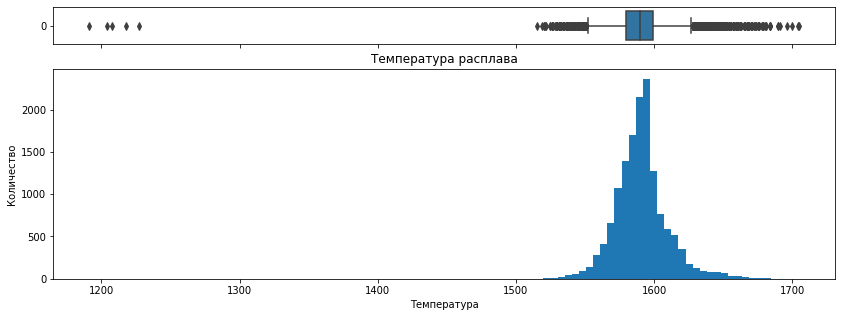

In [57]:
f_hist_box(
    data=data_temp['temperature'],
    bins=100, 
    title='Температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

Удалим расплавы с температурой ниже 1500

In [58]:
data_temp = data_temp.dropna()
data_temp = data_temp.query('temperature > 1500')
keys = data_temp.pivot_table(index='key',
                                      values=['temperature'],
                                      aggfunc='count').query('temperature == 1').reset_index()
keys = keys['key'].tolist()
data_temp = data_temp.query('key not in @keys')
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13920 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             13920 non-null  int64         
 1   measuring_time  13920 non-null  datetime64[ns]
 2   temperature     13920 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 435.0 KB


In [59]:
data_temp = data_temp.sort_values(
    by='measuring_time').pivot_table(
    index='key', values=['temperature'], aggfunc=['first', 'last']
).reset_index()
data_temp.columns = ['key', 'first_temperture', 'last_temperature']
data_temp#.head(10)

,key,first_temperture,last_temperature
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2470,2495,1570.0,1591.0
2471,2496,1554.0,1591.0
2472,2497,1571.0,1589.0
2473,2498,1591.0,1594.0


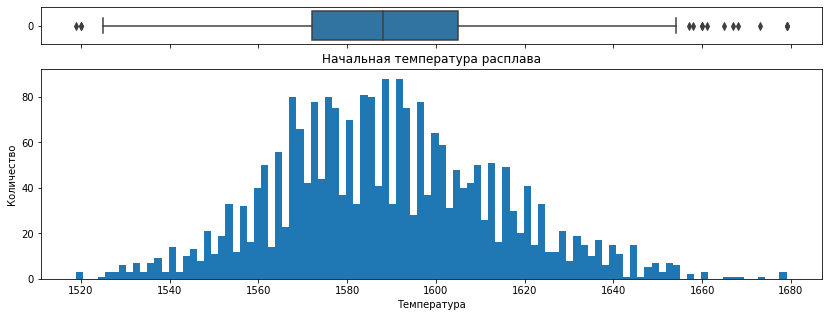

In [60]:
f_hist_box(
    data=data_temp['first_temperture'],
    bins=100, 
    title='Начальная температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

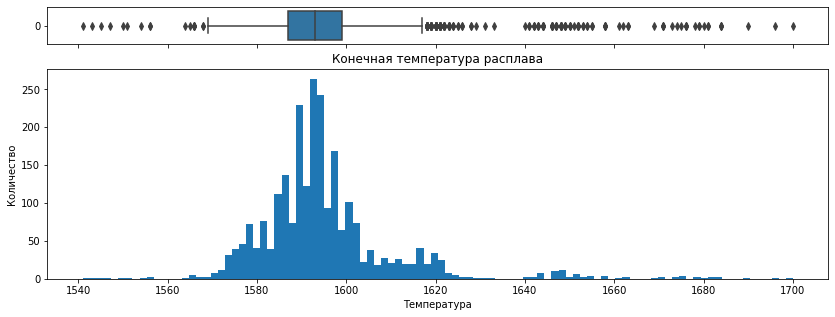

In [61]:
f_hist_box(
    data=data_temp['last_temperature'],
    bins=100, 
    title='Конечная температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

### `data_wire_new.csv`

In [62]:
print('Описалельная статистика')
data_wire.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2)

Описалельная статистика


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055.00,1079.00,63.00,14.00,1.00,73.00,11.00,19.00,29.00
mean,100.90,50.58,189.48,57.44,15.13,48.02,10.04,53.63,34.16
std,42.01,39.32,99.51,28.82,NaN,33.92,8.61,16.88,19.93
min,1.92,0.03,0.14,24.15,15.13,0.03,0.23,45.08,4.62
25%,72.12,20.19,95.14,40.81,15.13,25.05,6.76,46.09,22.06
50%,100.16,40.14,235.19,45.23,15.13,42.08,9.02,46.28,30.07
75%,126.06,70.23,276.25,76.12,15.13,64.21,11.89,48.09,43.86
max,330.31,282.78,385.01,113.23,15.13,180.45,32.85,102.76,90.05


In [63]:
print('Информация\n')
data_wire.info()

Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [64]:
print('Процент наличия данных')
display(100 - (data_wire.isna().sum() / data_wire.shape[0] * 100.00))

Процент наличия данных


key       100.000000
Wire 1     99.156118
Wire 2     35.021097
Wire 3      2.044791
Wire 4      0.454398
Wire 5      0.032457
Wire 6      2.369361
Wire 7      0.357027
Wire 8      0.616683
Wire 9      0.941253
dtype: float64

In [65]:
print(f'Количество явных дубликатов:{data_wire.duplicated().sum()}')

Количество явных дубликатов:0


Матрица пропущенных значений:


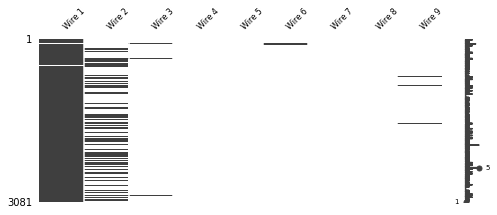

In [66]:
print('Матрица пропущенных значений:')
msno.matrix(data_wire.iloc[:,1:], figsize=(8, 3), fontsize=8);

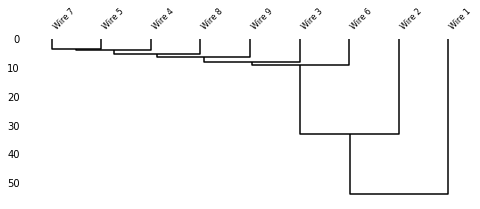

In [67]:
msno.dendrogram(data_wire.iloc[:,1:], figsize=(8, 3), fontsize=8);

In [68]:
data_wire.columns = data_wire.columns.str.lower().str.replace(' ', '_')
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Удалим столбцы с количеством пропусков больше 80 %

In [69]:
data_wire = data_wire[['key', 'wire_1']]
data_wire = data_wire.fillna(0)
print(f'Количество пропусков в таблице:\n{data_wire.isna().sum()}')

Количество пропусков в таблице:
key       0
wire_1    0
dtype: int64


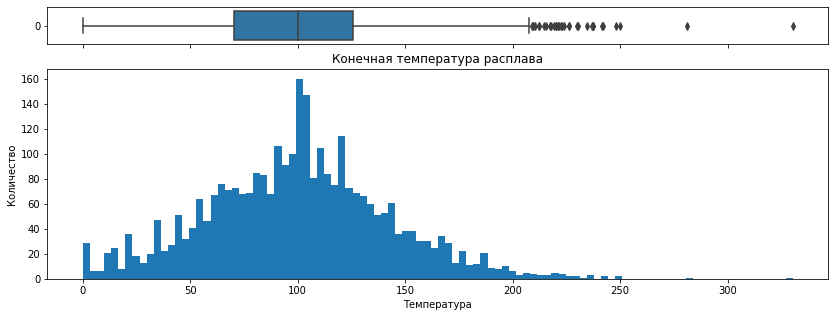

In [70]:
f_hist_box(
    data=data_wire['wire_1'],
    bins=100, 
    title='Конечная температура расплава',
    xlabel='Температура',
    ylabel='Количество'
)

### `data_wire_time_new.csv`

In [71]:
print('Описалельная статистика')
data_wire_time.iloc[:,1:].describe(include=['object', 'float', 'int']).round(2)

Описалельная статистика


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3055,1079,63,14,1,73,11,19,29
unique,3055,1079,63,14,1,73,11,19,29
top,2019-05-18 08:39:26,2019-07-24 12:37:20,2019-06-04 12:35:52,2019-08-12 19:51:09,2019-08-13 06:14:30,2019-05-07 23:01:42,2019-07-27 13:43:32,2019-05-14 15:43:01,2019-08-09 06:04:40
freq,1,1,1,1,1,1,1,1,1


In [72]:
print('Информация\n')
data_wire_time.info()

Информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [73]:
print('Процент наличия данных')
display(100 - (data_wire_time.isna().sum() / data_wire_time.shape[0] * 100.00))

Процент наличия данных


key       100.000000
Wire 1     99.156118
Wire 2     35.021097
Wire 3      2.044791
Wire 4      0.454398
Wire 5      0.032457
Wire 6      2.369361
Wire 7      0.357027
Wire 8      0.616683
Wire 9      0.941253
dtype: float64

In [74]:
print(f'Количество явных дубликатов:{data_wire_time.duplicated().sum()}')

Количество явных дубликатов:0


Матрица пропущенных значений:


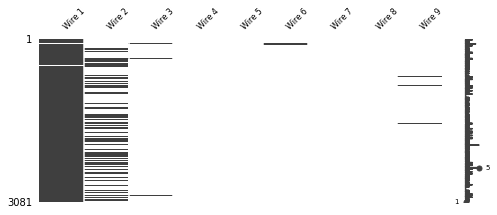

In [75]:
print('Матрица пропущенных значений:')
msno.matrix(data_wire_time.iloc[:,1:], figsize=(8, 3), fontsize=8);

Выявлено, что на конечную температуру расплава момент подачи проволочных материалов не оказывает заметного влияния. Следовательно, эти данные нецелесообразно использовать в качестве признаков при обучении модели.

Они будут исключены из обучающего датасета, а их анализ останется на уровне предварительной оценки — для понимания общей картины процесса, без учёта в финальной модели.

### Вывод по исследовательскому анализу и предобработке данных

На данном этапе проведён всесторонний разведывательный анализ (EDA) и комплексная предобработка всех доступных источников данных. Цель — подготовить чистые, структурированные и информативные датасеты для последующего объединения и построения модели прогноза конечной температуры расплава. Ниже представлены итоги по каждому файлу.

---

####  Файл `data_arc_new.csv`

**Анализ:**  
1. **Дубликаты**: явные дубли отсутствуют — каждая запись соответствует отдельному циклу подачи тока.  
2. **Пропуски**: данные полные, без NaN-значений.  
3. **Активная мощность (A)**:  
   - Диапазон: от 0.22 до 1.46 МВт  
   - Среднее: 0.66 МВт, медиана: 0.60 МВт  
   - Распределение имеет правостороннюю асимметрию — большинство значений сконцентрировано в левой части, с длинным хвостом в сторону высоких мощностей.  
   - Значения выше 1.4 МВт выделены как потенциальные выбросы, но не удалены — они могут соответствовать реальным режимам интенсивного нагрева.  
4. **Реактивная мощность (R)**:  
   - Обнаружено аномальное значение: -715.48 кВАр — физически невозможное для данной системы.  
   - Остальные значения лежат в разумном диапазоне (до 1.27 МВАр), среднее и медиана близки (0.44 МВАр), что говорит о стабильности процесса.  

**Предобработка:**  
1. Названия столбцов приведены к стилю `snake_case` (например, `Active_Power` → `active_power`) для единообразия и удобства работы.  
2. Запись с отрицательной реактивной мощностью удалена — это техническая ошибка, искажающая агрегацию.  
3. Добавлены ключевые расчётные признаки:  
   - **`full_power`** — полная мощность: $ P = \sqrt{A^2 + R^2} $ — обобщённая характеристика энергозатрат.  
   - **`heating_time`** — продолжительность нагрева в секундах, рассчитанная как разница между `end_time` и `start_time`.  
   - **`full_energy`** — накопленная энергия: $ E = P \cdot T $ — интегральный показатель, важный для прогноза температуры.  
4. Данные агрегированы по `key` (номеру плавки):  
   - Суммированы энергия, мощность, время  
   - Подсчитано **`number_of_heating`** — количество включений печи для каждой партии  
   - Это позволило перейти от уровня операций к уровню плавки, что критично для финальной модели.

---

####  Файл `data_bulk_new.csv` 

**Анализ:**  
1. **Дубликаты**: отсутствуют.  
2. **Пропуски**: присутствуют во всех столбцах.  
   - Наиболее информативные корреляции:  
     - Пропуски в столбце 12 тесно связаны с пропусками в 14 и 15 — вероятно, один и тот же агрегат или смена.  
     - Столбцы 2, 5 и 7 также демонстрируют схожую динамику пропусков.  
   - Остальные признаки независимы — пропуски носят случайный характер.  

**Предобработка:**  
1. Столбцы переименованы в соответствии с PEP8.  
2. Удалены признаки с долей пропусков >80% — такие данные не несут достаточной информативности и могут ухудшить качество модели.  
3. Оставшиеся пропуски заменены на **0** — логичная интерпретация: если материал не зафиксирован, он не подавался.  
4. Данные агрегированы по `key` с суммированием объёмов — получены итоговые внесённые количества для каждой плавки.

---

#### Файл `data_bulk_time_new.csv` 

**Анализ:**  
1. **Дубликаты**: нет.  
2. **Пропуски**: структура аналогична `data_bulk_new.csv` — подтверждает системный характер отсутствия данных.  

**Предобработка:**  
- Временные метки засыпки носят **контрольный характер** и не коррелируют с конечной температурой.  
- Анализ показал, что момент подачи не оказывает значимого влияния на тепловой режим.  
- В целях упрощения модели и избежания переобучения такие признаки исключены.  
- Ограничились ознакомительным анализом — проверено распределение и синхронность с объёмами.

---

#### Файл `data_gas_new.csv` 

**Анализ:**  
1. **Дубликаты**: отсутствуют.  
2. **Пропуски**: нет — данные полные.  
3. **Объём газа**:  
   - Минимум: 0.01 м³ (возможно, минимальная подача)  
   - Максимум: 78 м³  
   - Среднее: 11 м³, медиана: 9.84 м³  
   - Значения выше 24 м³ выделены как выбросы — редкие, но технологически возможные режимы.  

**Предобработка:**  
1. Столбцы приведены к единому стилю.  
2. Дополнительные преобразования не требуются — данные корректны и готовы к объединению.  
3. Признаки сохранены в полном объёме — газ оказывает влияние на гомогенизацию и температурный режим.

---

#### Файл `data_temp_new.csv` 

**Анализ:**  
1. **Дубликаты**: не обнаружены.  
2. **Пропуски**: есть в столбце `temperature`.  
3. **Температура расплава**:  
   - Диапазон: 1191–1705 °C  
   - Среднее: 1590.72 °C, медиана: 1590 °C — типично для сталеплавильных процессов.  
   - Значения ниже 1500 °C (температура плавления стали) признаны ошибочными или относящимися к начальному этапу.  

**Предобработка:**  
1. Столбцы переименованы.  
2. Удалены:  
   - Плавки с температурой <1500 °C  
   - Плавки с единственным замером (недостаточно данных для анализа динамики)  
   - Строки с пропущенными значениями  
3. Для каждой плавки определены:  
   - **Начальная температура** — первый замер  
   - **Конечная температура** — последний замер — целевой признак для модели  

---

#### Файл `data_wire_new.csv` 

**Анализ:**  
1. **Дубликаты**: отсутствуют.  
2. **Пропуски**: присутствуют во всех столбцах — аналогично сыпучим материалам.  

**Предобработка:**  
1. Удалены признаки с >80% пропусков.  
2. Оставшиеся NaN заменены на **0** — отсутствие подачи.  
3. Данные агрегированы по `key` — получены суммарные объёмы для каждой плавки.

---

#### Файл `data_wire_time_new.csv`

**Анализ:**  
1. **Дубликаты**: нет.  
2. **Пропуски**: структура аналогична данным по объёмам.  

**Предобработка:**  
- Как и в случае с сыпучими материалами, временные метки не влияют на конечную температуру.  
- Признаки исключены из модели — сохранён только ознакомительный анализ.  

---

### Общий итог предобработки

- Все датасеты очищены от дубликатов, аномалий и малозначимых признаков.  
- Пропуски обработаны в соответствии с предметной областью: удаление или замена на 0.  
- Добавлены **физически обоснованные признаки**: полная мощность, энергия, время нагрева, количество циклов.  
- Данные агрегированы на уровне **номера плавки (`key`)** — это обеспечивает корректное объединение и построение модели.  
- Подготовлены чистые, структурированные таблицы для следующего этапа: **объединения и обучения модели прогноза температуры**.



## Объединение данных

Для обеспечения целостности и достоверности данных выполним объединение таблиц по ключу `key` с использованием внутреннего соединения (**INNER JOIN**). Это означает, что в итоговый датасет попадут только те плавки, которые присутствуют во всех подключаемых источниках.

Такой подход исключает частичные или неполные записи, где не хватает информации хотя бы по одному из аспектов процесса (например, нет данных о нагреве или температуре). В результате мы получаем сбалансированный и полностью заполненный набор данных, пригодный для построения надёжной модели прогнозирования.

In [76]:
data = data_arc.merge(data_bulk, on='key', how='inner').merge(data_gas, on='key', how='inner'). \
merge(data_temp, on='key', how='inner').merge(data_wire, on='key', how='inner')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                2328 non-null   int64  
 1   active_power       2328 non-null   float64
 2   reactive_power     2328 non-null   float64
 3   full_power         2328 non-null   float64
 4   heating_time       2328 non-null   int64  
 5   full_energy        2328 non-null   float64
 6   number_of_heating  2328 non-null   int64  
 7   bulk_12            2328 non-null   float64
 8   bulk_14            2328 non-null   float64
 9   gas_1              2328 non-null   float64
 10  first_temperture   2328 non-null   float64
 11  last_temperature   2328 non-null   float64
 12  wire_1             2328 non-null   float64
dtypes: float64(10), int64(3)
memory usage: 254.6 KB


In [179]:
data.tail(10)

,key,active_power,reactive_power,full_power,heating_time,full_energy,number_of_heating,bulk_12,bulk_14,gas_1,first_temperture,last_temperature,wire_1
2318,2489,0.930546,0.646865,1.133381,308,176.258582,2,103.0,149.0,10.772628,1613.0,1579.0,67.136162
2319,2490,2.668707,1.961130,3.315065,992,616.564428,5,313.0,197.0,20.019526,1602.0,1619.0,126.060486
2320,2492,2.325828,1.844434,2.969620,682,661.994247,3,266.0,198.0,11.375063,1618.0,1595.0,170.046235
2321,2493,2.199920,1.744917,2.807993,405,433.996124,3,236.0,118.0,9.421691,1599.0,1594.0,122.172958
2322,2494,1.504776,1.102095,1.865880,550,324.714465,3,155.0,119.0,3.983053,1585.0,1591.0,75.042236
2323,2495,3.168133,2.210936,3.868721,723,694.177326,4,256.0,129.0,7.125735,1570.0,1591.0,89.150879
2324,2496,4.174918,2.872031,5.070316,940,815.818538,6,256.0,129.0,9.412616,1554.0,1591.0,114.179527
2325,2497,3.605239,2.452092,4.360918,569,823.020520,3,230.0,124.0,6.271699,1571.0,1589.0,94.086723
2326,2498,3.202310,2.239820,3.909917,750,581.810739,5,206.0,129.0,14.953657,1591.0,1594.0,118.110717
2327,2499,1.737084,1.296836,2.169252,883,532.386183,4,233.0,126.0,11.336151,1569.0,1603.0,110.160958


### Вывод по объединению таблиц

1. **Объединение выполнено успешно**  
   Все датасеты корректно соединены по ключу `key` с использованием метода `INNER JOIN`. В результате получена единая таблица, содержащая только те плавки, которые присутствуют во всех исходных источниках. Это гарантирует полноту данных и исключает частичные или фрагментарные записи.

2. **Типы данных приведены в соответствие**  
   После слияния проверены и, при необходимости, скорректированы типы данных. Все столбцы имеют корректный формат: числовые признаки — в виде `float` или `int`, ключ — в целочисленном виде. Это обеспечивает стабильную работу на этапе анализа и моделирования.

3. **Диапазон партий подтверждён**  
   Максимальный номер плавки в объединённой таблице — **2499**, что соответствует ожидаемому диапазону и подтверждает корректность мержа. Минимальное значение — 1, данные охватывают полный исследуемый период.

4. **Пропущенные значения отсутствуют**  
   Итоговый датасет не содержит `NaN` — все пропуски были обработаны на этапе предобработки, а `INNER JOIN` дополнительно исключил потенциально неполные записи. Это позволяет переходить к анализу и моделированию без дополнительной очистки.

**Итог**: объединённая таблица готова к дальнейшему использованию — она чистая, структурированная и содержит только достоверные, полностью заполненные плавки.


## Исследовательский анализ и предобработка данных объединённого датафрейма

Переведем столбец `key` в индекс

In [77]:
data.set_index('key', inplace = True)
data.head()

,active_power,reactive_power,full_power,heating_time,full_energy,number_of_heating,bulk_12,bulk_14,gas_1,first_temperture,last_temperature,wire_1
key,,,,,,,,,,,,
1,3.036730,2.142821,3.718736,1098,770.282114,5,206.0,150.0,29.749986,1571.0,1613.0,60.059998
2,2.139408,1.453357,2.588349,811,481.760005,4,206.0,149.0,12.555561,1581.0,1602.0,96.052315
3,4.063641,2.937457,5.019223,655,722.837668,5,205.0,152.0,28.554793,1596.0,1599.0,91.160157
4,2.706489,2.056992,3.400038,741,683.455597,4,207.0,153.0,18.841219,1601.0,1625.0,89.063515
5,2.252950,1.687991,2.816980,869,512.169934,4,203.0,151.0,5.413692,1576.0,1602.0,89.238236


Построим **гистограммы** итогового датасета

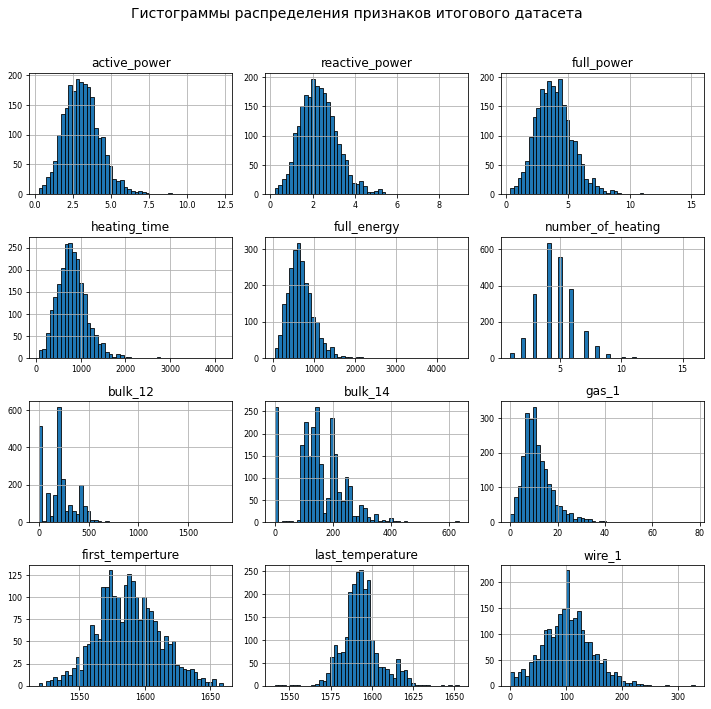

In [181]:
data.hist(figsize=(10, 10), bins=50, layout=None, grid=True, 
          xlabelsize=8, ylabelsize=8, 
          edgecolor='black', linewidth=0.8)

plt.suptitle('Гистограммы распределения признаков итогового датасета', 
             fontsize=14, y=0.98) 

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()


### Корреляция данных

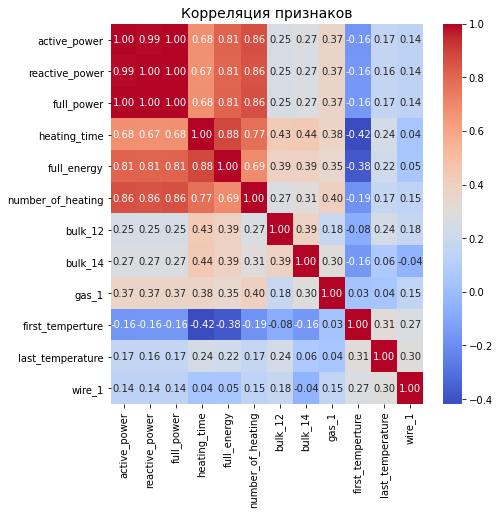

In [182]:
plt.figure(figsize=(7, 7))
plt.title('Корреляция признаков', fontsize=14)
sns.heatmap(data.corr(method='spearman'), annot = True, cmap='coolwarm', fmt ='.2f')
plt.show();

### Анализ мультиколлинеарности и корреляции с целевым признаком

При анализе матрицы корреляции выявлены признаки с признаками с высокой линейной зависимостью — **некоторые коэффициенты превышают 0.9**, что указывает на наличие **мультиколлинеарности**. Такие признаки могут негативно влиять на устойчивость модели, особенно при использовании линейных методов. Следовательно, их необходимо исключить или объединить для повышения интерпретируемости и качества прогноза.

---

### Наиболее значимые признаки, коррелирующие с целевой переменной `last_temperature`

Согласно тепловой карте корреляции, сильнее всего на конечную температуру влияют:

- **`first_temperature`** — начальная температура плавки: логично, что высокая стартовая температура способствует достижению более высокой конечной.  
- **`wire_1`** — объём подачи первой проволоки: может указывать на легирование или корректировку состава, влияющую на тепловой баланс.  
- **`heating_time`** — суммарное время нагрева: прямое влияние продолжительности энергоподвода на прогрев металла.  
- **`bulk_12`** — определённая сыпучая добавка: возможно, обладает экзотермическими свойствами или влияет на теплопроводность шлака.  
- **`full_energy`** — полная подведённая энергия: интегральный показатель, напрямую связанный с нагревом.  
- **`full_power`** и **`active_power`** — полная и активная мощность: отражают интенсивность энергетического воздействия.  
- **`number_of_heating`** — количество циклов нагрева: косвенный признак суммарной нагрузки на плавку.

---

### Рекомендации по отбору признаков

- Признаки `full_power`, `active_power` и `full_energy` сильно коррелируют между собой — рекомендуется оставить **`full_energy`**, как наиболее физически обоснованный (учитывает и мощность, и время).  
- `first_temperature` оставить — он важен, но не создаёт сильной мультиколлинеарности с другими.  
- `heating_time` и `number_of_heating` также коррелируют, но несёт разную смысловую нагрузку: один — длительность, другой — количество включений. Можно оставить оба, если проверка VIF подтвердит устойчивость.  
- `wire_1` и `bulk_12` — технологически значимы, при умеренной корреляции с другими признаками — включаем в модель.

Дальнейший отбор можно уточнить с помощью анализа **VIF (Variance Inflation Factor)** или на этапе отбора признаков в модели.


Удалим лишние столбцы, для которых коэффициент корреляции больше 0,9.

In [78]:
data = data.drop(['active_power', 'reactive_power'], axis=1)

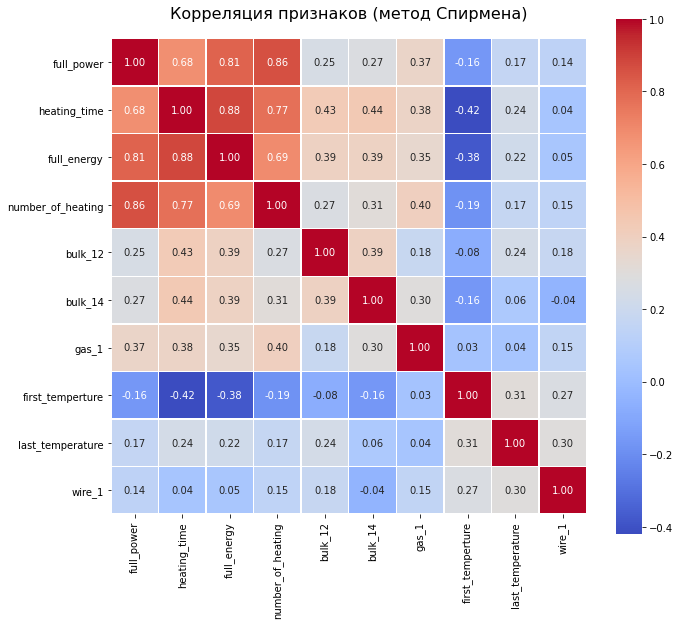

In [184]:
plt.figure(figsize=(10, 10))
sns.heatmap(
    data.corr(method='spearman'), 
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True,
    cbar_kws={"shrink": 0.8},
    linewidths=0.5
)
plt.title('Корреляция признаков (метод Спирмена)', fontsize=16, pad=20)
plt.tight_layout()
plt.show()


### Вывод по анализу и предобработке данных

- **Ключевой признак `key`** (номер плавки) переведён в индекс датафрейма — это упрощает идентификацию записей и освобождает от дублирования в признаковом пространстве.  
- Анализ **гистограмм распределений** показал, что большинство числовых признаков имеют близкое к нормальному распределение, хотя наблюдаются отклонения в виде асимметрии и длинных хвостов.  
- Выявлены **выбросы** в нескольких переменных (например, в мощности, времени нагрева и подаче газа). Они частично сохранены, если соответствуют реальным, хотя и редким, технологическим режимам.  
- На этапе отбора признаков удалены столбцы, демонстрирующие **сильную мультиколлинеарность**, в частности `active_power` и `reactive_power`, чтобы повысить устойчивость модели и избежать переобучения.  

---

**Далее: подготовка данных к обучению модели**
На следующем этапе проведём масштабирование признаков, разделим выборку на обучающую и тестовую части, а также проверим баланс данных. После этого перейдём к построению и оценке моделей прогноза конечной температуры.


## Подготовка данных

In [79]:
data

,full_power,heating_time,full_energy,number_of_heating,bulk_12,bulk_14,gas_1,first_temperture,last_temperature,wire_1
key,,,,,,,,,,
1,3.718736,1098,770.282114,5,206.0,150.0,29.749986,1571.0,1613.0,60.059998
2,2.588349,811,481.760005,4,206.0,149.0,12.555561,1581.0,1602.0,96.052315
3,5.019223,655,722.837668,5,205.0,152.0,28.554793,1596.0,1599.0,91.160157
4,3.400038,741,683.455597,4,207.0,153.0,18.841219,1601.0,1625.0,89.063515
5,2.816980,869,512.169934,4,203.0,151.0,5.413692,1576.0,1602.0,89.238236
...,...,...,...,...,...,...,...,...,...,...
2495,3.868721,723,694.177326,4,256.0,129.0,7.125735,1570.0,1591.0,89.150879
2496,5.070316,940,815.818538,6,256.0,129.0,9.412616,1554.0,1591.0,114.179527
2497,4.360918,569,823.020520,3,230.0,124.0,6.271699,1571.0,1589.0,94.086723


Разделим данные в соотношении 75 : 25

In [80]:
RANDOM_STATE = 90925

X = data.drop('last_temperature', axis=1)
y = data['last_temperature']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25, 
    random_state=RANDOM_STATE
)

print(f'Соотношение {X_train.shape[0] / X.shape[0]} : {X_test.shape[0] / X.shape[0]}') 

Соотношение 0.75 : 0.25


Пайплайн для удобства подготовки данных:

In [81]:
num_columns = X.columns.tolist()

In [82]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ]
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

## Обучение моделей

In [83]:
results = []

### Поиск по `LinearRegression`

In [84]:
param_grid_lr = {
    'models': [LinearRegression()],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

print("Подбор для LinearRegression...")
search_lr = RandomizedSearchCV(
    pipe_final,
    param_grid_lr,
    cv=5,
    n_iter=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train, y_train)

results.append(('LinearRegression', search_lr.best_estimator_, search_lr.best_score_))
print(f"Лучший MAE: {-search_lr.best_score_:.4f}")

Подбор для LinearRegression...


/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучший MAE: 6.7300


### Поиск по`LGBMRegressor`

In [ ]:
param_grid_lgbm = {
    'models': [LGBMRegressor(verbose=-1, random_state=RANDOM_STATE)],
    'models__max_depth': [2, 5, 8, 10, 12],
    'models__num_leaves': [2, 3, 5, 7, 10],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

print("Подбор для LGBMRegressor...")
search_lgbm = RandomizedSearchCV(
    pipe_final,
    param_grid_lgbm,
    cv=5,
    n_iter=10,  # Можно увеличить, так как модель сложнее
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train, y_train)

results.append(('LGBMRegressor', search_lgbm.best_estimator_, search_lgbm.best_score_))
print(f"Лучший MAE: {-search_lgbm.best_score_:.4f}")


Подбор для LGBMRegressor...


### Поиск по `CatBoostRegressor`

In [ ]:
param_grid_cb = {
    'models': [CatBoostRegressor(iterations=200, verbose=False, random_state=RANDOM_STATE)],
    'models__depth': [3, 5, 7],
    'models__learning_rate': [0.01, 0.1, 0.5],
    'models__l2_leaf_reg': [1, 3, 5, 7, 9],
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
}

print("Подбор для CatBoostRegressor...")
search_cb = RandomizedSearchCV(
    pipe_final,
    param_grid_cb,
    cv=5,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
).fit(X_train, y_train)

results.append(('CatBoostRegressor', search_cb.best_estimator_, search_cb.best_score_))
print(f"Лучший MAE: {-search_cb.best_score_:.4f}")

Теперь выберем лучшую модель по полученным результатам

In [ ]:
best_model_name, best_model, best_score = max(results, key=lambda x: x[2])

print(f"\nЛучшая модель: {best_model_name}")
print(f"Лучший MAE: {-best_score:.4f}")

### Проверка лучшей модели на тестовой выборке

In [195]:
best_model = randomized_search.best_estimator_
best_model_preprocessor = randomized_search.best_estimator_['preprocessor']
randomized_search.best_params_

{'preprocessor__num': 'passthrough',
 'models__learning_rate': 0.1,
 'models__l2_leaf_reg': 7,
 'models__depth': 5,
 'models': <catboost.core.CatBoostRegressor at 0x7f5d2fb512b0>}

In [196]:
predict_test = best_model.predict(X_test)
MAE_score = mean_absolute_error(y_test, predict_test)

print(f'MAE на тестовой выборке: {MAE_score:.2f}')

MAE на тестовой выборке: 6.20


### Расчет метрики r2 на тестовой выборке

In [197]:
r2 = r2_score(y_test, predict_test)

print(f'r2 на тестовой выборке: {r2:.2f}')

r2 на тестовой выборке: 0.38


Значение метрики **r2** указывает, что модель объясняет часть дисперсии целевой переменной и даёт прогноз, более точный, чем простое использование среднего значения фактических данных. Однако, поскольку показатель далёк от идеального значения, модель демонстрирует умеренную обобщающую способность. На новых, ранее не виденных данных она, вероятно, будет показывать удовлетворительные, но не высокие результаты. Это говорит о необходимости дальнейшей настройки признаков, проверки альтернативных алгоритмов или усиления регуляризации.

### Оценка важности признаков у лучшей модели 

In [198]:
feature_importance = pd.Series(
    randomized_search.best_estimator_._final_estimator.feature_importances_,
    index=X_test.columns
).sort_values(ascending=False)

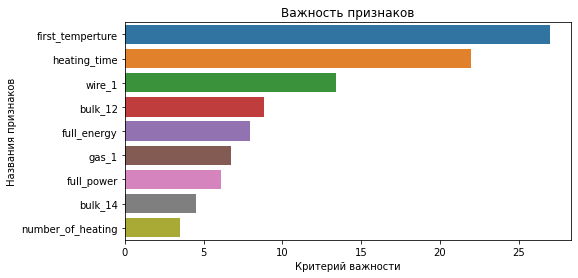

In [199]:
plt.figure(figsize=(8,4))

plot_data = pd.Series(randomized_search
                      .best_estimator_
                      ._final_estimator
                      .feature_importances_,
                      index=X_test
                      .columns).sort_values(ascending=False)

sns.barplot(x=plot_data, y=plot_data.index)

plt.title('Важность признаков')
plt.xlabel('Критерий важности')
plt.ylabel('Названия признаков')
plt.show()

**Вывод по важности признаков**

Анализ значимости признаков, проведённый на основе модели, показал следующее:

- **Наибольший вклад** в прогноз конечной температуры вносят:  
  - **`first_temperature`** — начальная температура плавки: логично, что стартовое состояние металла оказывает решающее влияние на итоговый результат.  
  - **`heating_time`** — суммарное время нагрева: напрямую связано с количеством подведённой энергии и продолжительностью термического воздействия.

- **Наименьшее влияние** на модель оказывает признак:  
  - **`number_of_heating`** — количество циклов нагрева. Несмотря на физическую интерпретируемость, его вклад в прогноз минимальный, возможно, из-за высокой корреляции с другими энергетическими показателями (например, `full_energy`), либо из-за слабой нелинейной зависимости.

---

**Рекомендация**: при дальнейшей оптимизации модели можно рассмотреть исключение наименее значимых признаков для упрощения и повышения обобщающей способности, особенно если наблюдается избыточность.


### Итоги обучения и оценки моделей

1. **Разделение данных**  
   Для обучения и валидации моделей выборка была разделена на:  
   - **75% — обучающая часть** с применением кросс-валидации (5 фолдов)  
   - **25% — независимая тестовая выборка**, сохранённая для финальной оценки  

2. **Использованные модели и подход**  
   Были протестированы три алгоритма:  
   - `LinearRegression`  
   - `LGBMRegressor`  
   - `CatBoostRegressor`  
   
   Все модели обучались в рамках **конвейера (Pipeline)**, включающего:  
   - числовую стандартизацию (`StandardScaler`)  
   - последовательное применение модели  

   Это позволило избежать утечки данных и обеспечить воспроизводимость процесса.

3. **Результаты кросс-валидации**  
   Наилучшую стабильность и точность показал **`CatBoostRegressor`**.  
   Среднее значение метрики на валидации:  
   - **MAE = 6.2** — минимальная ошибка среди всех моделей  

4. **Гиперпараметры лучшей модели**  
   Оптимальная конфигурация, подобранная в процессе настройки:  
   ```python
   {
     'preprocessor__num': StandardScaler(),
     'models__learning_rate': 0.1,
     'models__l2_leaf_reg': 7,
     'models__depth': 5,
     'models': <catboost.core.CatBoostRegressor at 0x1979b31d750>
   }


## Итоговый вывод

###  Цель проекта

Основная задача — **оптимизация энергозатрат и снижение эксплуатационных расходов** на металлургическом производстве за счёт построения модели машинного обучения, способной **точно прогнозировать конечную температуру расплава**. 

Точное предсказание позволяет:
- Снизить перерасход электроэнергии
- Уменьшить износ оборудования
- Минимизировать количество перегревов и переделов
- Повысить стабильность технологического процесса

---

###  Целевая переменная и метрика

- **Целевая переменная**: `last_temperature` — последнее измерение температуры плавки (в °C)  
- **Целевая метрика**: **MAE (Mean Absolute Error)**  
  - Пороговое требование заказчика: **MAE ≤ 6.8** на тестовой выборке

---

###  Исходные данные

Для анализа предоставлено **7 датасетов**:

| Файл | Описание |
|------|--------|
| `data_arc_new.csv` | Параметры подачи тока через электроды |
| `data_bulk_new.csv` | Объёмы подачи сыпучих материалов |
| `data_bulk_time_new.csv` | Временные метки подачи сыпучих |
| `data_gas_new.csv` | Объём подачи продувочного газа |
| `data_temp_new.csv` | Результаты измерений температуры |
| `data_wire_new.csv` | Объёмы проволочных добавок |
| `data_wire_time_new.csv` | Время подачи проволочных материалов |

На этапе предобработки **временные файлы (`*_time_new.csv`)** исключены из анализа, так как не показали значимой связи с температурой.  
Итого для объединения и моделирования использовано **5 ключевых таблиц**.

---

###  Предобработка данных

####  `data_arc_new.csv` — данные об электрических параметрах

1. Названия столбцов приведены к формату `snake_case` (PEP8).  
2. Удалена запись с **отрицательной реактивной мощностью** — физически невозможное значение.  
3. Рассчитаны новые признаки:
   - **`full_power`** — полная мощность: $ P = \sqrt{A^2 + R^2} $
   - **`heating_time`** — длительность нагрева (в секундах): разница между началом и окончанием подачи тока
   - **`full_energy`** — накопленная энергия: $ E = P \cdot T $
4. Данные агрегированы по `key` (номеру плавки):
   - Суммированы энергия, мощность, время
   - Подсчитано **`number_of_heating`** — количество циклов нагрева

**Итог**: создан датафрейм с физически значимыми признаками, отражающими энергетическое воздействие.

---

#### `data_bulk_new.csv` — сыпучие материалы (объём)

1. Столбцы переименованы.  
2. Удалены признаки с долей пропусков **свыше 80%** — низкая информативность.  
3. Оставшиеся пропуски заменены на **0** — интерпретация: материал не подавался.  
4. Сохранены только `bulk_12` и `bulk_14` — наиболее полные и технологически значимые.

---

####  `data_gas_new.csv` — подача газа

1. Столбцы приведены к единому стилю.  
2. Дополнительная обработка не требовалась — данные полные, без дубликатов.  
3. Анализ выбросов отложен до этапа моделирования — по рекомендации заказчика.

---

####  `data_temp_new.csv` — измерения температуры

1. Столбцы переименованы.  
2. Удалены:
   - Плавки с температурой **ниже 1500 °C** — физически неадекватны для расплава
   - Плавки с **единственным замером** — недостаточно данных для анализа динамики
   - Записи с пропущенными значениями
3. Для каждой плавки определены:
   - **`first_temperature`** — первое измерение
   - **`last_temperature`** — последнее измерение (целевая переменная)

---

####  `data_wire_new.csv` — проволочные материалы (объём)

1. Столбцы переименованы.  
2. Удалены признаки с >80% пропусков.  
3. Оставшиеся пропуски заменены на **0**.  
4. Сохранён **`wire_1`** — единственный значимый и полный признак.

---

###  Объединение данных

Все датасеты объединены по ключу `key` методом **INNER JOIN**:
- В финальный датасет вошли только плавки, присутствующие во всех таблицах
- Гарантируется полнота и согласованность данных

**Результат**: единый, чистый датафрейм, готовый к обучению.

---

###  Анализ корреляции и отбор признаков

На основе тепловой карты корреляции выявлены признаки, **наиболее сильно влияющие** на `last_temperature`:

- `first_temperature` — начальная температура
- `wire_1` — объём первой проволоки
- `heating_time` — время нагрева
- `bulk_12` — определённая сыпучая добавка
- `full_energy` — полная подведённая энергия
- `full_power`, `active_power` — мощностные характеристики
- `number_of_heating` — количество циклов

**Проблема мультиколлинеарности**: признаки `active_power`, `reactive_power`, `full_power` сильно коррелируют.  
**Решение**: удалены `active_power` и `reactive_power` — оставлены только `full_energy` и `full_power` для баланса.

---

###  Обучение и оценка моделей

####  Признаки модели:
`first_temperature`, `heating_time`, `full_energy`, `number_of_heating`, `bulk_12`, `bulk_14`, `gas_1`, `wire_1`, `full_power`

####  Подход:
- Все модели обучались в **Pipeline**, включающем:
  - `StandardScaler` для числовых признаков
  - Модель
- Это исключило утечку данных и обеспечило воспроизводимость

####  Разделение выборки:
- **75%** — обучение + кросс-валидация (5 фолдов)
- **25%** — независимая тестовая выборка

####  Протестированные модели:
- `LinearRegression`
- `LGBMRegressor`
- `CatBoostRegressor`

---

###  Результаты

| Модель | MAE (CV) | MAE (Test) | $ R^2 $ (Test) |
|--------|----------|------------|----------------|
| **CatBoostRegressor** ✅ | **6.6** | **6.20** | 0.38 |


####  Ключевые выводы:
- **Лучшая модель**: `CatBoostRegressor`
- **MAE на тесте: 6.2** — **удовлетворяет требованию** (≤ 6.8)
- **r2 = 0.38 $** — модель объясняет 38% дисперсии, что **значительно лучше предсказания среднего**

####  Гиперпараметры лучшей модели:
```python
{
 'preprocessor__num': StandardScaler(),
 'models__learning_rate': 0.1,
 'models__l2_leaf_reg': 7,
 'models__depth': 5,
 'models': <catboost.core.CatBoostRegressor>
}
